In [2]:
# %config Completer.use_jedi = False
#hide
#!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *
import math
fastbook.setup_book()



/home/art/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Multicat

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
def getx(e): return path/'train'/e['fname']
def gety(e): return e['labels'].split(' ')
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x = getx,
    get_y = gety,
    splitter = (lambda df: (df.index[~df['is_valid']].tolist(), df.index[df['is_valid']].tolist())),
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
)
dls = dblock.dataloaders(df)

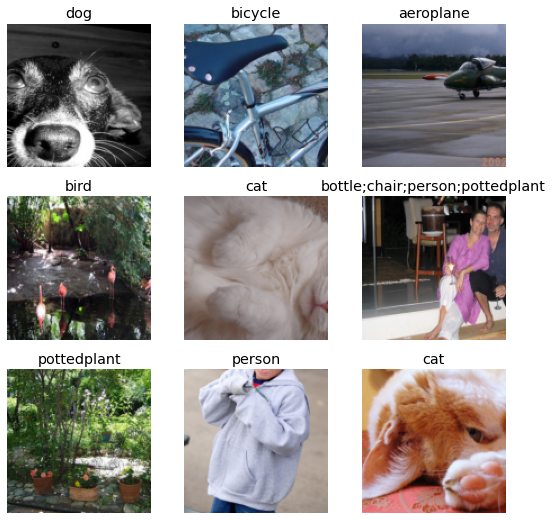

In [6]:
dls.show_batch()

In [9]:
def my_accuracy(inputs, targets, threshold=0.5, is_sigmoid=True):
    if is_sigmoid: inputs = inputs.sigmoid()
    return ((inputs >= threshold) == targets.bool()).float().mean()

In [11]:
learn = cnn_learner(dls, resnet18, metrics=partial(my_accuracy, threshold=0.5))

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
learn.loss_func, learn.metrics

(FlattenedLoss of BCEWithLogitsLoss(),
 (#1) [<fastai.learner.AvgMetric object at 0x7fac6f4864d0>])

In [12]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,my_accuracy,time
0,0.993774,0.745706,0.573287,00:17
1,0.870180,0.581029,0.711693,00:16
2,0.644232,0.219892,0.944681,00:16
3,0.390888,0.142085,0.949821,00:16


epoch,train_loss,valid_loss,my_accuracy,time
0,0.154073,0.125751,0.954343,00:18
1,0.137858,0.121780,0.955996,00:18
2,0.120818,0.118781,0.956653,00:18


In [15]:
pred, targets = learn.get_preds()
pred, targets

(TensorBase([[0.0025, 0.0047, 0.0064,  ..., 0.1657, 0.0019, 0.3311],
         [0.0008, 0.0028, 0.0009,  ..., 0.0041, 0.0012, 0.0006],
         [0.0013, 0.0603, 0.0010,  ..., 0.0091, 0.0012, 0.0017],
         ...,
         [0.0080, 0.0103, 0.0039,  ..., 0.0213, 0.0022, 0.0064],
         [0.0298, 0.0123, 0.0025,  ..., 0.0156, 0.1336, 0.0045],
         [0.0053, 0.4006, 0.0138,  ..., 0.1876, 0.0056, 0.0378]]),
 TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]))

In [16]:
my_accuracy(pred, targets, threshold=0.9, is_sigmoid=False),  my_accuracy(pred, targets, threshold=0.1, is_sigmoid=False),  my_accuracy(pred, targets, threshold=0.5, is_sigmoid=False)

(TensorMultiCategory(0.9491),
 TensorMultiCategory(0.9140),
 TensorMultiCategory(0.9567))

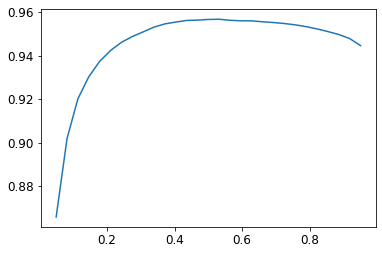

In [17]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(pred, targets, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

[(Path('/storage/data/pascal_2007/test/003084.jpg'), (#1) ['person']),
 (Path('/storage/data/pascal_2007/test/005193.jpg'), (#2) ['cat','dog']),
 (Path('/storage/data/pascal_2007/test/001634.jpg'), (#1) ['boat'])]

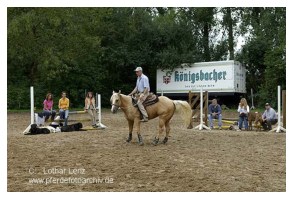

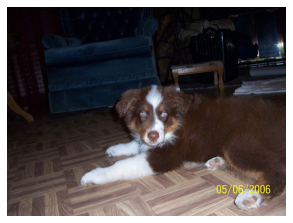

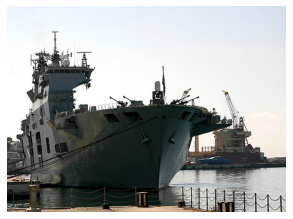

In [29]:
samples = (path/'test').ls()[1,10,11]
res = []
for s in samples:
    show_image(Image.open(s))
    res += [(s, learn.predict(s)[0])]
res

## Regression

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
path.ls()

(#50) [Path('/home/art/.fastai/data/biwi_head_pose/08'),Path('/home/art/.fastai/data/biwi_head_pose/19'),Path('/home/art/.fastai/data/biwi_head_pose/07.obj'),Path('/home/art/.fastai/data/biwi_head_pose/13.obj'),Path('/home/art/.fastai/data/biwi_head_pose/02.obj'),Path('/home/art/.fastai/data/biwi_head_pose/17'),Path('/home/art/.fastai/data/biwi_head_pose/15.obj'),Path('/home/art/.fastai/data/biwi_head_pose/21.obj'),Path('/home/art/.fastai/data/biwi_head_pose/12'),Path('/home/art/.fastai/data/biwi_head_pose/05.obj')...]

In [7]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [8]:
get_ctr(img_files[10])

tensor([419.3272, 254.4824])

In [9]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='19'),
    batch_tfms=[*aug_transforms(size=(240,320)),
    Normalize.from_stats(*imagenet_stats)]
)

In [10]:
dls = biwi.dataloaders(path)

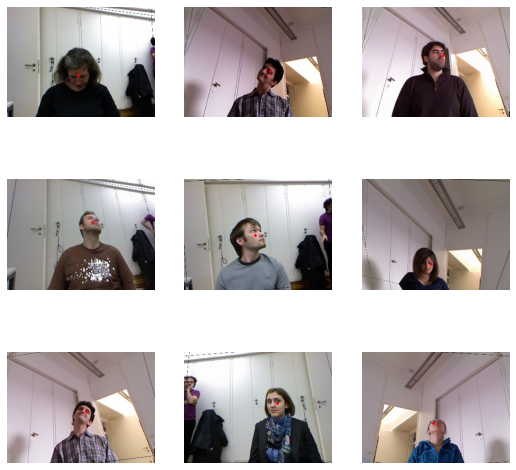

In [11]:
dls.show_batch()

In [17]:
xd, yd = dls.one_batch()
xd.shape, yd.shape, xd[0][0], yd[0]

(torch.Size([64, 3, 240, 320]),
 torch.Size([64, 1, 2]),
 TensorImage([[ 0.8749,  0.8548,  0.8325,  ...,  2.2400,  2.1881,  2.2310],
         [ 0.8597,  0.8597,  0.8597,  ...,  2.2480,  2.2350,  2.2456],
         [ 0.8598,  0.8597,  0.8597,  ...,  2.2358,  2.2131,  2.2090],
         ...,
         [-0.9185, -0.0082,  0.3996,  ..., -2.0919, -2.1093, -2.0841],
         [-0.7930,  0.1136,  0.4010,  ..., -2.0922, -2.1091, -2.0841],
         [-0.6610,  0.2041,  0.4010,  ..., -2.1072, -2.1119, -2.1008]]),
 TensorPoint([[-0.0875,  0.1749]]))

In [18]:
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

/home/art/.local/lib/python3.10/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [19]:
learn.lr_find()

KeyboardInterrupt: 